<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Защита персональных данных клиентов

Нам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработаем такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуем корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Загрузка данных

Фиксируем параметры:

In [1]:
#random seed
SEED = 12345
#all cores but one
NJOBS = -2

Подключаем библиотеки для работы:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

Загружаем датасет в пандас:

In [3]:
df = pd.read_csv('./datasets/insurance.csv')

Просмотрим кратко информацию, первые строки и статистику:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [5]:
df.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [6]:
df.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Проверим на пропуски и дубликаты:

In [7]:
df.isna().sum()

Пол                  0
Возраст              0
Зарплата             0
Члены семьи          0
Страховые выплаты    0
dtype: int64

In [8]:
df.duplicated().sum()

153

Выбросим явные дубликаты:

In [9]:
df = df.drop_duplicates(ignore_index=True)

Оценим гистограммы распределения параметров:

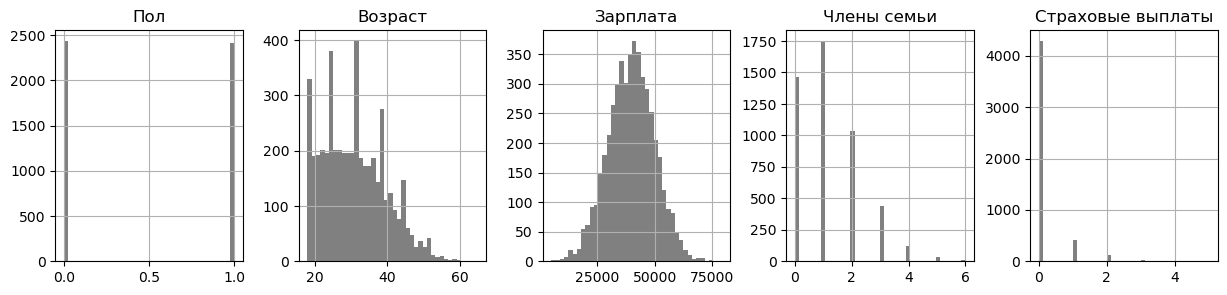

In [10]:
# изуально оценим гистограммы распределения параметров
df.hist(figsize=(15, 3),
        color='grey',
        bins=40,
        layout=(1, 5));

**Выводы**
- Зарплата имеет нормальное распределение
- Возраст распределен нормально с выбросами, которые стоило бы изучить при необходимости обучать более качественные модели, но по условию ТЗ мы разрабатываем алгоритм шифрования, а не занимаемся faeture-engineering
- Пол распределен равномерно
- Подавляющее большинство клиентов выплаты не получало. *Страховые компании всегда в плюсе* :)

Для красоты приведем типы данных:

In [11]:
df['Возраст'] = df['Возраст'].astype(int)
df['Зарплата'] = df['Зарплата'].astype(int)
df.dtypes

Пол                  int64
Возраст              int32
Зарплата             int32
Члены семьи          int64
Страховые выплаты    int64
dtype: object

Подготовим выборки для обучения моделей:

In [12]:
features = df.drop('Страховые выплаты', axis=1)
target = df['Страховые выплаты']
print(features.shape, target.shape)

(4847, 4) (4847,)


Разделим выборки на обучающую и тестовую:

In [13]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=SEED)
print(features_train.shape, target_train.shape, features_test.shape, target_test.shape)

(3877, 4) (3877,) (970, 4) (970,)


Подготовим скелер для фич:

In [14]:
#учим скелер на трейн фичах
scaler = StandardScaler()
scaler.fit(features_train) 
#и применяем ко всем
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

## Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $Z$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Задача:**

Ответьте на вопрос и обоснуйте решение: признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново)
- a) Изменится. Приведите примеры матриц.
- b) Не изменится. Укажите, как связаны параметры линейной регрессии в исходной задаче и в преобразованной.

**Решение**

Для проверки утверждения подставим в формулу обучения (расчета) весов линейной регрессии вместо исходной матрицы $X$, произведение $XZ$, где $Z$ - некоторая обратимая матрица. 

Обратимость означает:
- Матрица является квадратной
- Существует матрица, обратная заданной
- Произведение матрицу на обратную дает в результате единичную матрицу

Таким образом, новые коэффициенты $w$:

$$
w = ((X Z)^T X Z)^{-1} (X Z)^T y
$$


Первое произведение $ (XZ)^T $ по правилу *`транспонированное произведение матриц равно произведению транспонированных матриц, взятых в обратном порядке`*:

$$
(XZ)^T = Z^T X^T
$$


$$
w = (Z^T X^T X Z)^{-1} Z^T X^T y
$$

После перегруппировки множителей в скобках:

$$
w = (Z^T (X^T X) Z)^{-1} Z^T X^T y
$$

Для обратной матрицы произведения действует то же правило, что и для транспонирования: *`обратное произведение матриц равно произведению обратных матриц, взятых в обратном порядке`*

Таким образом:

$$
(Z^T (X^T X) Z)^{-1} = ((X^T X) Z)^{-1} (Z^T)^{-1}
$$

Далее:

$$
((X^T X) Z)^{-1} (Z^T)^{-1} = Z^{-1} (X^T X)^{-1} (Z^T)^{-1}
$$

При подстановке в формулу весов:

$$
w = Z^{-1} (X^T X)^{-1} (Z^T)^{-1} Z^T X^T y
$$

Из определения обратимой матрицы $Z$ следует, что произведение $(Z^T)^{-1} Z^T$ равно единичной матрице $E$.

Тогда:

$$
w = Z^{-1} (X^T X)^{-1} E X^T y = Z^{-1} (X^T X)^{-1} X^T y
$$

Можно заметить, что окончательно получилась *`формула для исходных весов обучения`* $w = (X^T X)^{-1} X^T y$.

Переназовем новые веса $w1$ для наглядности и получаем:

$$
w1 = Z^{-1} w
$$

Подставляем пересчитанное значение весов  𝑤1 в формулу для предсказаний линейной регрессии $a = Xw$:

Новые предсказания $a1$:

$$
a1 = (XZ) w1 = X Z Z^{-1} w
$$

Из условия обратимости $Z$ , произведение $Z Z^{-1}$ равно единичной матрице $E$:

$$
a1 = X Z Z^{-1} w = X E w = X w = a
$$

Таким образом, мы показали, что предсказания $a1$ для матрицы признаков, умноженных на обратимую матрицу $Z$ **`равны`** предсказаниям $a$.

**Ответ:** 
- Итак, верный ответ b)
- Мы показали, что предсказания $a = a1$ не изменяются, что позволяет шифровать персональные данные
- Однако, так как $w1 = Z^{-1} w$, модель необходимо будет переучить для новых закодированных трейн фичей (сам вектор весов изменяется)

## Алгоритм преобразования

**Алгоритм**

Исходя из доказательства в пункте 2, нам необходимо подготовить некоторую (случайную) обратимую матрицу квадратную размера **количество_фич + 1** (для свободного члена сдвига):

In [15]:
features.shape[1]

4

Для воспроизводимости результатов работаем с фиксированным сидом (при реальном шифровании нам нужно сохранить матрицу $Z$, чтоб была возможность восстановить фичи:

In [16]:
np.random.seed(seed=SEED)

In [17]:
encryption_matrix = np.random.rand(features.shape[1]+1, features.shape[1]+1)
encryption_matrix

array([[0.92961609, 0.31637555, 0.18391881, 0.20456028, 0.56772503],
       [0.5955447 , 0.96451452, 0.6531771 , 0.74890664, 0.65356987],
       [0.74771481, 0.96130674, 0.0083883 , 0.10644438, 0.29870371],
       [0.65641118, 0.80981255, 0.87217591, 0.9646476 , 0.72368535],
       [0.64247533, 0.71745362, 0.46759901, 0.32558468, 0.43964461]])

Проблем с обратимостью не должно быть, но проверим:

In [18]:
encryption_matrix_inverted = np.linalg.inv(encryption_matrix)
encryption_matrix_inverted 

array([[ 0.05300921, -5.42869373,  1.95811063,  3.90519895,  0.24316421],
       [-0.79259668,  1.5545168 ,  0.45507685, -1.23780401,  0.44089954],
       [-1.01469721, -1.86006878, -1.52718938,  0.22954762,  4.73521289],
       [-0.39405943, -3.28917676,  2.59124521,  4.86014825, -4.36217887],
       [ 2.58701085,  9.81060585, -3.8988123 , -7.53029379, -0.60611279]])

Домножим матрицу на обратную и получим $E$:

In [19]:
np.round(encryption_matrix @ encryption_matrix_inverted, 2)

array([[ 1., -0., -0.,  0., -0.],
       [ 0.,  1., -0., -0., -0.],
       [-0.,  0.,  1.,  0., -0.],
       [ 0.,  0., -0.,  1., -0.],
       [ 0.,  0., -0., -0.,  1.]])

Промоделируем предсказания по формулам из пункта 2 с учетом свободного члена:

In [20]:
features_train_shift = np.concatenate((np.ones((features_train.shape[0], 1)), features_train), axis=1)
features_train_shift.shape

(3877, 5)

Также заранее добавим сдвиг в тестовые фичи:

In [21]:
features_test_shift = np.concatenate((np.ones((features_test.shape[0], 1)), features_test), axis=1)
features_test_shift.shape

(970, 5)

Рассчитаем веса w по формуле обучения $w = (X^T X)^{-1} X^T y$:

In [22]:
weights = np.linalg.inv(features_train_shift.T @ features_train_shift) @ features_train_shift.T @ target_train
weights

array([ 0.15398504,  0.00762637,  0.30962457,  0.0017981 , -0.01546259])

Рассчитаем вектор предсказаний по формуле $a = Xw$:

In [23]:
predictions = features_train_shift @ weights
predictions

array([ 0.05201493, -0.03009608,  0.41993373, ..., -0.23868148,
        0.23710286,  0.50094371])

Рассчитаем веса для матрицы домноженной на обратимую $Z$ по формуле $w = ((X Z)^T X Z)^{-1} (X Z)^T y$:

In [24]:
weights_encryption = np.linalg.inv((features_train_shift @ encryption_matrix).T @ features_train_shift @ encryption_matrix) @\
                (features_train_shift @ encryption_matrix).T @ target_train
weights_encryption

array([ 0.57630258,  0.02166711, -0.71609504,  0.7927391 , -0.738156  ])

И новые предсказания:

In [25]:
predictions_encryption = features_train_shift @ encryption_matrix @ weights_encryption
predictions_encryption

array([ 0.05201493, -0.03009608,  0.41993373, ..., -0.23868148,
        0.23710286,  0.50094371])

In [26]:
np.isclose(predictions, predictions_encryption).mean()

1.0

Отобразим полученные веса на графике:

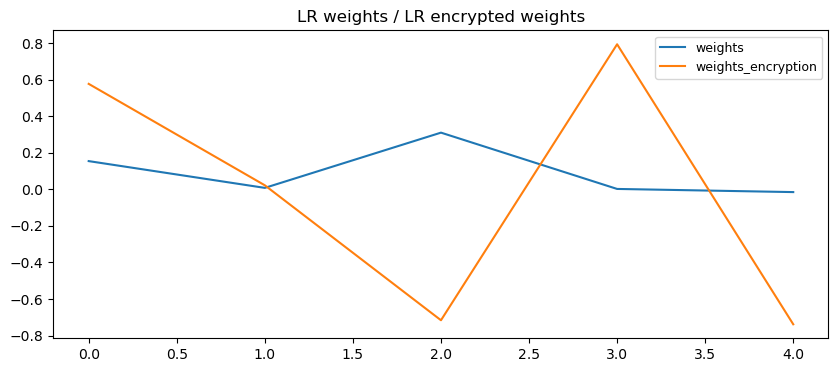

In [27]:
plt.figure(figsize=(10,4))
ax = sns.lineplot(weights, label='weights')
sns.lineplot(weights_encryption,
             label='weights_encryption',
             ax=ax)
plt.legend(prop={'size': 9})
plt.title('LR weights / LR encrypted weights');

И первые 100 точек из обоих векторов предсказаний:

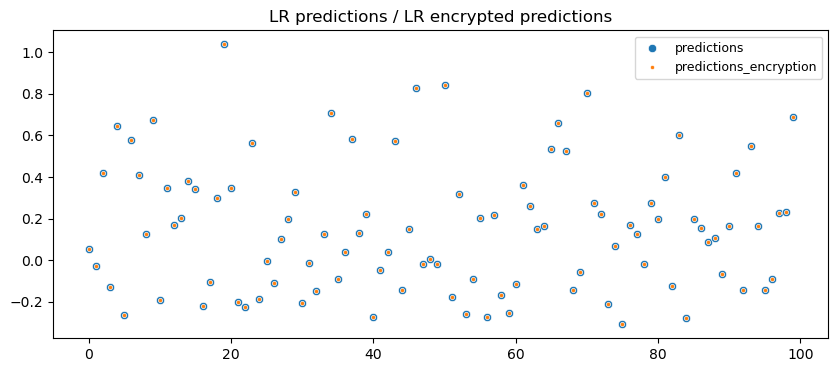

In [28]:
plt.figure(figsize=(10,4))
ax = sns.scatterplot(predictions[0:100],
                     label='predictions',
                     marker='o'
                  )
sns.scatterplot(predictions_encryption[0:100],
             label='predictions_encryption',
             ax=ax,
             marker='.')
plt.legend(prop={'size': 9})
plt.title('LR predictions / LR encrypted predictions');

**Вывод**
Таким образом, доказанная формула проверена для произвольной матрицы $Z$ и фич features_train

## Проверка алгоритма

Будем обучать две модели линейной регрессии:

In [29]:
lr = LinearRegression(n_jobs=NJOBS)
lr_encryption = LinearRegression(n_jobs=NJOBS)

In [30]:
lr.fit(features_train, target_train)
predictions_test = lr.predict(features_test)
print('r2 score', r2_score(target_test, predictions_test))

r2 score 0.4160549229827962


In [31]:
lr_encryption.fit(features_train_shift @ encryption_matrix, target_train)
predictions_test_encryption = lr_encryption.predict(features_test_shift @ encryption_matrix)
print('r2 score', r2_score(target_test, predictions_test_encryption))

r2 score 0.4159821422185458


In [32]:
np.isclose(predictions_test, predictions_test_encryption).mean()

0.0

**Вывод**
- r2 score обеих моделей совпадают
- Предсказания обеих моделей совпадают

## Общий вывод

- Предложен и опробован алгоритм шифрования данных клиентов перед применением модели линейной регрессии
- Стоит отметить, что чем больше фич представлено, тем сложнее будет потенциальному взломщику подобрать матрицу для восстановления персональных данных
- Необходимо применять OHE-кодирование категориальных фич (пол клиента). Однако в датасете, по сути, это кодирование уже предвыполнено